# SEQUENCE PROCESSING USING RECURRENT NEURAL NETWORKS

_**Univariate and Multivariate Time-series Forcasting using Recurrent Neural Networks (RNNs).**_

The following experiment considers Chicago Transit Authority (CTA) daily ridership dataset. This dataset is available at https://data.cityofchicago.org/ and shows system-wide boardings for both bus and rail services provided by CTA. The dataset with updates from January 01, 2001 through August 1, 2024 was considered in this experiment.

In [1]:
# Imports required packages

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

2025-02-26 21:40:07.625136: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 21:40:07.625902: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 21:40:07.629579: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 21:40:07.641076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740586207.660817   45973 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740586207.66

## Retrieving Data

In [2]:
# Loads the dataset
ridership = pd.read_csv(
    "./../data/CTA-Ridership-Daily_Boarding_Totals_20240829.csv", 
    parse_dates=["service_date"]  # To consider column as a date coumn if it contains date represented as text
)

# Shows the dataset
display(ridership)

,service_date,day_type,bus,rail_boardings,total_rides
0,2001-01-01,U,297192,126455,423647
1,2001-01-02,W,780827,501952,1282779
2,2001-01-03,W,824923,536432,1361355
3,2001-01-04,W,870021,550011,1420032
4,2001-01-05,W,890426,557917,1448343
...,...,...,...,...,...
8578,2024-04-26,W,554146,355278,909424
8579,2024-04-27,A,419731,286199,705930
8580,2024-04-28,U,293589,196481,490070
8581,2024-04-29,W,556233,349857,906090


Note: Attribute value **W**, **A** ans **U** in column **day_type** represent **Weekday**, **Saturday** and **Sunday/Holiday**, respectively.

In [3]:
# Sets the column 'service_date' as index
ridership.set_index("service_date", inplace=True)

In [4]:
# Sorts dataset (in ascending order) by index "service_date" to make index monotonic considering
# it would be a requirement for slicing DataFrame with a datetime type based index
ridership.sort_index(inplace=True)

In [5]:
# Drops the calculated column "total_rides" as this is just element-wise addition 
# between columns "bus" and "rail_boardings".
ridership.drop("total_rides", axis=1, inplace=True)

## Data Analysis

<Axes: xlabel='service_date'>

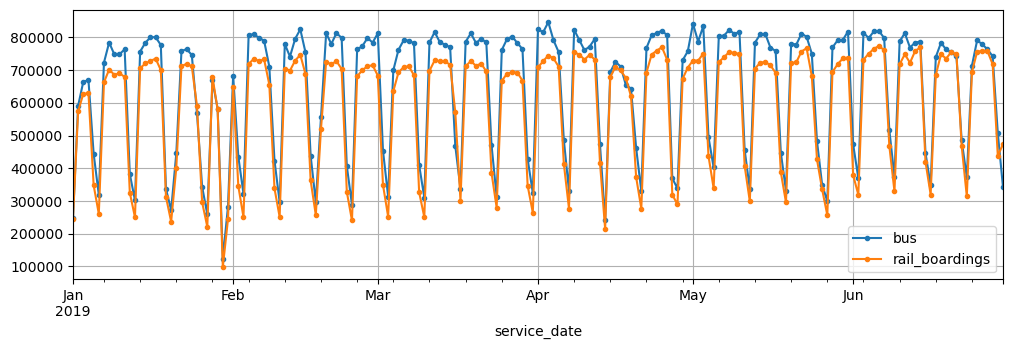

In [6]:
# Plots the bus and rail ridership over a few months in 2019
ridership["2019-01":"2019-06"].plot(grid=True, marker=".", figsize=(12, 3.5))

Weekly seasonality (repeating pattern) for both variables - bus and rail was observed by looking at the above figure.

## Modeling
_Models both univariate and multivariate forecasting using simple and deep RNNs._

### Univariate Forecasting

_Forecasting next days's rail ridership based (only) on rail ridership [single variable as input] of the past 8 weeks (56 days)._

**Prepares Datasets for Modeling**

Prepares input as sequences each containing 56 values from time steps (_t_ – 55) to _t_ for model to output a single value as a forecast for time step (_t_ + 1).

In [7]:
# Splits the time-series into three periods - for training, validation and testing
# The values are scaled down by a factor of one million, to ensure the values are near the 0–1 range

rail_train = ridership["rail_boardings"]["2016-01":"2018-12"] / 1e6  # 3 years
rail_val = ridership["rail_boardings"]["2019-01":"2019-06"] / 1e6    # 6 months
rail_test = ridership["rail_boardings"]["2019-07":] / 1e6            # remaining period from 2019-07 through 2024-04

In [8]:
# Prepares TensorFlow specific datasets

seq_length = 56    # represents sequence of past 8 weeks (56 days) of ridership data

tf.random.set_seed(42)  # Sets global random seed for operations that rely on a random seed

# Creates train set consists of sequences each containing 56 consecutive data points
rail_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),           # All consecutive data points (timesteps) converted from series to array
    targets=rail_train[seq_length:], # To set targets[i+seq_length]` as target corresponding to the window that starts at index `i`
    sequence_length=seq_length,      # Length of output sequence
    batch_size=32,                   # Number of sequences in each batch
    shuffle=True,                    # Shuffles the output sequences [required only for training]
    seed=42                          # Random seed for shuffling [required only if shuffling is set to True]
)

# Similarly, prepares validation and test set

rail_val_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_val.to_numpy(),
    targets=rail_val[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
)

rail_test_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_test.to_numpy(),
    targets=rail_test[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
)

2025-02-26 21:40:10.078055: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


#### Forecasting Using a Simple RNN

In [9]:
# Creates a sequential model with an RNN
univar_simple_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 1)),  # None indicates RNN to accept input sequence of any length
    tf.keras.layers.SimpleRNN(32),           # Simple RNN layer with 32 output recurrent neurons
    tf.keras.layers.Dense(1)                 # Output layer with one output neuron
])

In [10]:
# Compiles it with specific loss function, optimizer and metric
univar_simple_rnn.compile(
    loss="huber",                     # Huber loss is popular for RNN for regression task
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=["mae"])

In [11]:
# Fits the model
history = univar_simple_rnn.fit(
    rail_train_ds,
    validation_data=rail_val_ds, 
    epochs=500, 
    callbacks=[
        # Sets callback to stop training when model does improve after a certain number of training iterations
        tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
    ])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0442 - mae: 0.2148 - val_loss: 0.0076 - val_mae: 0.1025
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - mae: 0.0915 - val_loss: 0.0040 - val_mae: 0.0713
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mae: 0.0749 - val_loss: 0.0024 - val_mae: 0.0455
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - mae: 0.0647 - val_loss: 0.0021 - val_mae: 0.0377
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mae: 0.0596 - val_loss: 0.0024 - val_mae: 0.0444
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mae: 0.0535 - val_loss: 0.0032 - val_mae: 0.0591
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mae: 0.0534 - val_loss: 0.0021 - val_mae: 0.0406
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mae: 0.0560 - val_loss: 0.0019 - val_mae: 0.0331
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.00

In [12]:
# After training, model gets evaluated against validation and test set

val_loss, val_mae = univar_simple_rnn.evaluate(rail_val_ds)

print("\nValidation MAE of the Simple RNN: {:.0f}".format(val_mae * 1e6))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mae: 0.0288     

Validation MAE of the Simple RNN: 29450


#### Forecasting Using a Deep RNN

Now, checks if deep RNN (multiple layers of Simple RNN) works better than simple RNN.

In [13]:
tf.keras.backend.clear_session()    # Resets all the keras states

tf.random.set_seed(42)

# Creates a Deep RNN with multiple layers of simple RNN each with 32 recurrent neurons 
# followed by a dense output layer with one output neuron
univar_deep_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 1)),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),  # sequence-to-sequence layer
    tf.keras.layers.SimpleRNN(32, return_sequences=True),  # sequence-to-sequence layer
    tf.keras.layers.SimpleRNN(32),                         # sequence-to-vector layer
    tf.keras.layers.Dense(1)
])

In [14]:
# Compiles the model
univar_deep_rnn.compile(
    loss="huber",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=["mae"])

In [15]:
# Fits the model
history = univar_deep_rnn.fit(
    rail_train_ds, 
    validation_data=rail_val_ds, 
    epochs=500, 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
    ])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1186 - mae: 0.3264 - val_loss: 0.0063 - val_mae: 0.0914
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0067 - mae: 0.0850 - val_loss: 0.0026 - val_mae: 0.0500
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0050 - mae: 0.0674 - val_loss: 0.0025 - val_mae: 0.0478
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0043 - mae: 0.0610 - val_loss: 0.0022 - val_mae: 0.0424
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0042 - mae: 0.0590 - val_loss: 0.0022 - val_mae: 0.0436
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0040 - mae: 0.0596 - val_loss: 0.0022 - val_mae: 0.0449
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0040 - mae: 0.0557 - val_loss: 0.0019 - val_mae: 0.0368
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0038 - mae: 0.0551 - val_loss: 0.0019 - val_mae: 0.0363
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - lo

In [16]:
# After training, model gets evaluated against validation data

val_loss, val_mae = univar_deep_rnn.evaluate(rail_val_ds)

print("\nValidation MAE of the Deep RNN: {:.0f}".format(val_mae * 1e6))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0282     

Validation MAE of the Deep RNN: 29399


The above performance shows that deep RNN [Val. MAE: 29399] could not much better than simple RNN [Val. MAE: 29450]. Hence, deep RNN might not be a good fit for this case. Now, let's experiment with multivariate forecasting to check if it can improve model performance further.

### Multivariate Forecasting

_Forecasting next day's rail ridership based on both bus and rail ridership [multiple variables as input] of the past 8 weeks (56 days). Day type attribute [weekday, weekend, or a holiday] is also taken into consideration._

**Prepares Datasets for Modeling**

Prepares dataset with multiple features as input for modeling

In [17]:
ridership_multivar = ridership[["bus", "rail_boardings"]] / 1e6

# Considering next day could affect the present day's ridership, it
# creates attribute indicate the next day (as type 'W', 'A' and 'U')
ridership_multivar["next_day_type"] = ridership["day_type"].shift(-1)

# Encodes text type attribute into using one-hot (integer) encoding
ridership_multivar = pd.get_dummies(ridership_multivar, dtype=int)

# Shows the encoded multivariate dataset
display(ridership_multivar)

,bus,rail_boardings,next_day_type_A,next_day_type_U,next_day_type_W
service_date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0
...,...,...,...,...,...
2024-04-26,0.554146,0.355278,1,0,0
2024-04-27,0.419731,0.286199,0,1,0
2024-04-28,0.293589,0.196481,0,0,1


In [18]:
# Checks the shape of the multivariate dataset
ridership_multivar.shape

(8583, 5)

The above dataset is a DataFrame with five columns: 'bus', 'rail_boardings', plus three columns containing encoded values for next day.

In [19]:
# Splits the time-series into three periods - for training, validation and testing

multivar_train = ridership_multivar["2016-01":"2018-12"]  # 3 years
multivar_val = ridership_multivar["2019-01":"2019-06"]    # 6 months
multivar_test = ridership_multivar["2019-06":]            # remaining period from 2019-06 through 2024-04

In [20]:
# Prepares TensorFlow specific datasets

tf.random.set_seed(42)

multivar_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivar_train.to_numpy(),
    targets=multivar_train["rail_boardings"][seq_length:],  # to forecast only the rail ridership
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

multivar_val_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivar_val.to_numpy(),
    targets=multivar_val["rail_boardings"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

#### Forecasting Using a Simple RNN

In [21]:
# Resets all the keras states
tf.keras.backend.clear_session()

tf.random.set_seed(42)

# Creates an RNN with 32 recurrent neurons followed by a dense output layer with one output neuron
# The same model was used before for univariate forecasting, but it is now being used for multivariate forecasting
multivar_simple_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),  # Now, model accepts 5 inputs
    tf.keras.layers.SimpleRNN(32),   
    tf.keras.layers.Dense(1)
])

In [22]:
# Compiles it with specific loss function, optimizer and metric
multivar_simple_rnn.compile(
    loss="huber",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=["mae"])

In [23]:
# Fits the model
history = multivar_simple_rnn.fit(
    multivar_train_ds, 
    validation_data=multivar_val_ds, 
    epochs=500, 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
    ])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1016 - mae: 0.3498 - val_loss: 0.0094 - val_mae: 0.1237
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - mae: 0.0916 - val_loss: 0.0021 - val_mae: 0.0552
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mae: 0.0492 - val_loss: 8.8215e-04 - val_mae: 0.0300
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mae: 0.0413 - val_loss: 0.0014 - val_mae: 0.0431
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0400 - val_loss: 6.9997e-04 - val_mae: 0.0263
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mae: 0.0357 - val_loss: 8.4034e-04 - val_mae: 0.0298
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mae: 0.0371 - val_loss: 8.1826e-04 - val_mae: 0.0295
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mae: 0.0388 - val_loss: 8.1208e-04 - val_mae: 0.0292
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7

In [24]:
# After training, model gets evaluated against validation data

val_loss, val_mae = multivar_simple_rnn.evaluate(multivar_val_ds)

print("\nValidation MAE of the Multivariate Simple RNN: {:.0f}".format(val_mae * 1e6))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3878e-04 - mae: 0.0223 

Validation MAE of the Multivariate Simple RNN: 22643


**Observation:**

The above multivariate model that received 5 inputs instead of 1 in univariate model, performed much better with MAE of **22643** compared to that of simple RNN [MAE: **29450**], indicating the significance of multiple features in modeling.